<center><font size="6"><b>CV SEGA</b></font></center>
<p></p>
<center><font size="5"><b>Modélisation pour détection des bennes</b></font></center>
<br>
<br>
<br>

# Intentions

Détecter et entourer les bennes via des bounding box.

# Logs

Voir CV_SEGA_model_objdetect_versions.md

# Configuration du notebook

In [40]:
# Mode d'éxécution du notebook : "drive" ou "local"
work_mode = "local"

# Localisation des modèles pour les sauvegardes et les chargements
if work_mode == "drive":
    model_loc = "/drive/My Drive/CV_DS/..."
elif work_mode == "local":
    model_loc = "_models"

In [41]:
%%javascript
// Récupération du nom du notebook
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = "theNotebook = " + "'"+attribs['data-notebook-name'].value+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [42]:
# Récupération du nom notebook pour les sauvegardes de modèles et connection au drive et montage du drive
if work_mode == "drive":
    # Montage du drive
    from requests import get
    theNotebook = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    theNotebook = theNotebook[0:-6]
    print("Nom du notebook : ",theNotebook)
    
    # Montage du drive
    from google.colab import  drive
    drive.mount('/content/drive')

# Installer

In [43]:
if work_mode == "drive":
    !pip install swifter


# Modules et fonctions

## Import des modules


In [44]:
# Classics
import pandas as pd
import numpy as np
import random

# Opérations sur fichiers/dossiers
import os
from joblib import load, dump
import json
from glob import glob

# Viz
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import missingno as msno
%matplotlib inline

# Autres
from tqdm import tqdm
from collections import Counter
import pprint

# Tensorflow
import tensorflow as tf

# Preprocess
from sklearn.model_selection import train_test_split


## La cuisine

In [45]:
# Fonction d'affichage des BB
def show_img_bb (img, x, y, w, h,name):
    
    # Calcul des coordonnées
    w = np.abs(w)
    h = np.abs(h)
    x1 = np.abs(x)-w/2
    y1 = np.abs(y)-h/2
    x2= x1+w
    y2= y1+h
    
    # Affichage des coordonnées
    print(f"Coordonnées BB {name}")
    print(f'x:{x}',f'y:{y}',f'w:{w}',f'h:{h}')
    print(f'x1:{x1}',f'x2:{x2}',f'y1:{y1}',f'y2:{y2}')
    
    plt.imshow(img)
    plt.plot([x1,x2,x2,x1,x1], [y1,y1,y2,y2,y1], "r")
    plt.title("Image : " + name)
#     plt.show()

## Test GPU

In [9]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
sys_details = tf.sysconfig.get_build_info()
if tf.test.gpu_device_name():
    device_name = tf.test.gpu_device_name()
    print(f'GPU found : {device_name}')
    pprint.print(sys_details)
else:
    tf.config.list_physical_devices('CPU')
    print("No GPU found, CPU mode activated")
    pprint.pprint(sys_details)

AttributeError: module 'tensorflow._api.v1.sysconfig' has no attribute 'get_build_info'

# Chargement du dataset

## Bennes

In [46]:
# Lecture des données
if work_mode == "local":
#     data_path = "Z:/_pyworld/_kindergarten/_T_Datascientest/Projet cv SEGA/SEGA/datasets/container"
    data_path = "Z:/_pyworld/_kindergarten/_T_Datascientest/Projet cv SEGA/SEGA/datasets/container"

df = pd.read_csv(data_path + '/df_1_light.csv',index_col=0,converters={'bbox': pd.eval})
df = df.astype({'file_name':'string'})
df["file_name"] = df["file_name"].apply(lambda x: data_path + "/" + x)
display (df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1483 entries, 0 to 1482
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  1483 non-null   object
 1   bbox       1483 non-null   object
dtypes: object(2)
memory usage: 34.8+ KB


None

,file_name,bbox
0,Z:/_pyworld/_kindergarten/_T_Datascientest/Pro...,"[10, 0, 535, 289]"
1,Z:/_pyworld/_kindergarten/_T_Datascientest/Pro...,"[18, 46, 400, 224]"
2,Z:/_pyworld/_kindergarten/_T_Datascientest/Pro...,"[1, 51, 703, 606]"
3,Z:/_pyworld/_kindergarten/_T_Datascientest/Pro...,"[0, 135, 493, 287]"
4,Z:/_pyworld/_kindergarten/_T_Datascientest/Pro...,"[556, 77, 233, 186]"


In [47]:
def bbox_moy (x):
    x[0] = x[0] + x[2]/2
    x[1] = x[1] + x[3]/2
    return x


In [48]:
df["bbox_moy"] = df["bbox"].map(lambda x: bbox_moy (x) )

In [49]:
df.head()

,file_name,bbox,bbox_moy
0,Z:/_pyworld/_kindergarten/_T_Datascientest/Pro...,"[277.5, 144.5, 535, 289]","[277.5, 144.5, 535, 289]"
1,Z:/_pyworld/_kindergarten/_T_Datascientest/Pro...,"[218.0, 158.0, 400, 224]","[218.0, 158.0, 400, 224]"
2,Z:/_pyworld/_kindergarten/_T_Datascientest/Pro...,"[352.5, 354.0, 703, 606]","[352.5, 354.0, 703, 606]"
3,Z:/_pyworld/_kindergarten/_T_Datascientest/Pro...,"[246.5, 278.5, 493, 287]","[246.5, 278.5, 493, 287]"
4,Z:/_pyworld/_kindergarten/_T_Datascientest/Pro...,"[672.5, 170.0, 233, 186]","[672.5, 170.0, 233, 186]"


In [9]:
# Filtrage uniquement sur les formats JPEG
df = df[df["file_name"].str.contains(".jpeg")]

In [50]:
Ajouter les modifs

SyntaxError: invalid syntax (2244238236.py, line 1)

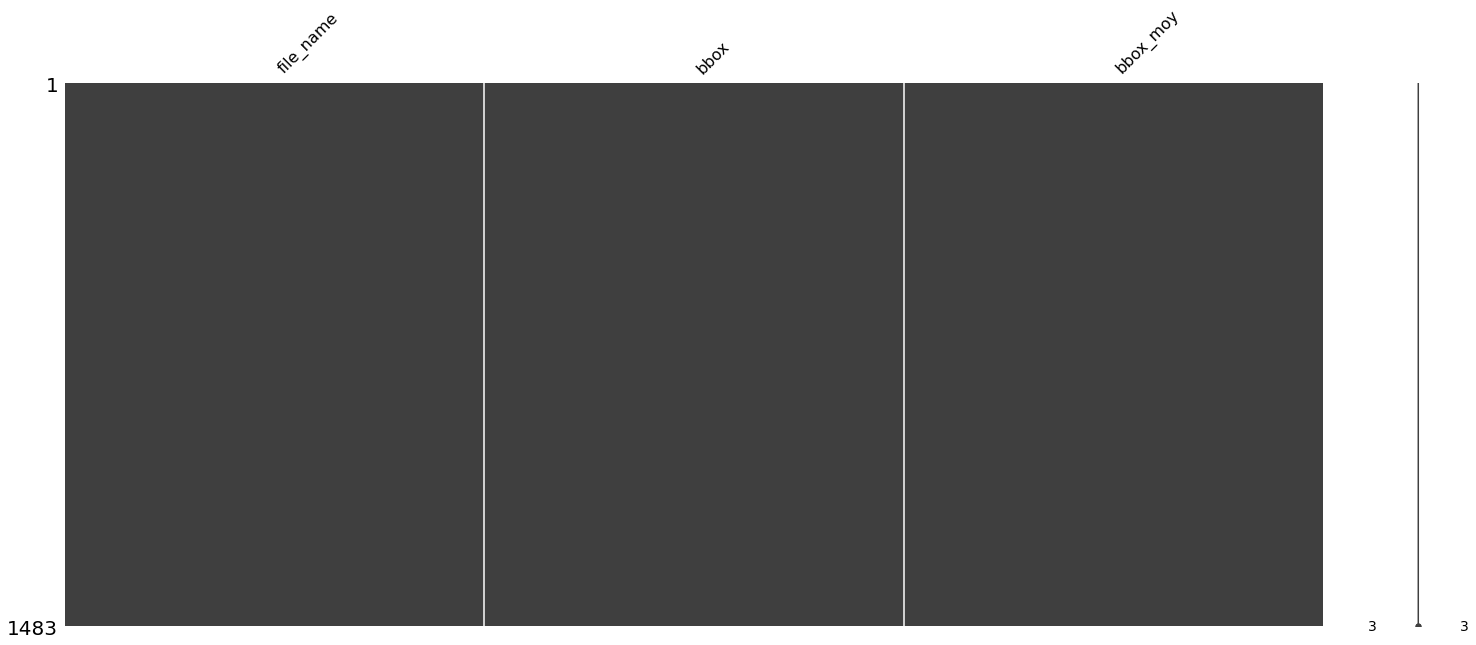

In [51]:
msno.matrix(df)

## Stanford BG

On ajoute ici le dataset stanford background afin d'assurer la fonction de détection d'objets. Le modèle pourra ainsi fournir une sortie avec l'information de la présence ou de l'absence de benne.

In [52]:
# Return all path in folder iccv09Data with .jpg extention
backgrounds_dir = 'Z:/_pyworld/_kindergarten/_T_Datascientest/Projet cv SEGA/SEGA/datasets/stanford_background/'
background_image_files = glob(backgrounds_dir +'**.jpg')

# load images in background_image list
background_image = []
for p in tqdm(background_image_files):
    img = plt.imread(p)
    background_image.append(img)

len(background_image)

100%|███████████████████████████████████████████████████████████████████████████████| 715/715 [00:04<00:00, 146.33it/s]


715

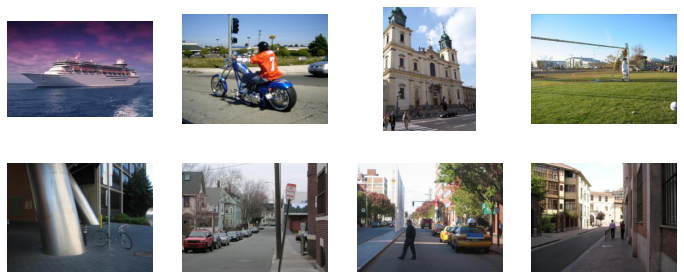

In [53]:
plt.figure(figsize=(12,5))
for j, im in enumerate(random.sample(background_image, 8)):
    plt.subplot(2,4,j+1)
    plt.axis('off')
    plt.imshow(im)

# Preprocessing

## Séparation

In [54]:
################ Réalisation des sets d'entrainnement et de tests
"""
    taille du set de test => 20 % des données restantes
    random_state => 42
"""

# Séparer la variable explicative de la variable à prédire
X, y = df["file_name"], df["bbox"].apply(lambda x: np.array(x)).to_list()

# X, X_test, y, y_test  = train_test_split(X, y, test_size=0.1,random_state = 42)
# X_train, X_val, y_train, y_val  = train_test_split(X, y, test_size=0.1,random_state = 42)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.1,random_state = 42)

## Fonctions de chargement set bennes

In [55]:
# Définition de la taille de redimensionnement
imgRsize = (256, 256)

In [56]:
Mettre à jour les fonctions

SyntaxError: invalid syntax (2974389904.py, line 1)

In [ ]:
@tf.function
def get_random_transform(X,y):
        
        def V_Flip(X,y):
            X = tf.image.flip_left_right(X)
            new_x = X.shape[0] - y[:2]
            new_y = tf.stack([new_x[0],new_x[1],y[2], y[3]],0)
            return X,new_y
        
        def Identity(X,y):
            return X,y
        
        # Génération aléatoire des transformations      
        p = tf.random.uniform(shape = [1], minval=0, maxval=1, dtype=tf.dtypes.int32)
                
        X,y = tf.cond(p == 0 ,lambda: Identity(X,y), lambda: Identity(X,y))
        X,y = tf.cond(p == 1 ,lambda: V_Flip(X,y), lambda: Identity(X,y))
        
        return X,y

In [57]:
def get_random_transform(X,y):

    def V_Flip(X,y):
        X = tf.image.flip_left_right(X)
        x_up = X.shape[1] - y[0]
        new_y = tf.stack([x_up,y[1],y[2], y[3]],0)
        return X,new_y

    def Identity(X,y):
        return X,y
        
    def img_slider(X, y):
        
        # Find the max translation to keep the object in the image
        tx_max = -(X.shape[1] - (y[0] + y[2]/2))
        tx_min = (y[0]-y[2]/2)
        ty_max = -(X.shape[0] - (y[1] + y[3]/2))
        ty_min = (y[1]-y[3]/2)

        # Choose a andom translation
        tx = np.random.uniform(tx_min.numpy(), tx_max.numpy())
        ty = np.random.uniform(ty_min.numpy(), ty_max.numpy())

        # Apply the transformation in the image
        X_new = tf.keras.preprocessing.image.apply_affine_transform(X.numpy(),theta=0,
                                                                 tx=tx,ty=ty,shear=0,
                                                                 zx=1,zy=1,row_axis=0,
                                                                 col_axis=1,channel_axis=2,
                                                                 fill_mode='nearest',cval=0.0,
                                                                 order=1
                                                                )
        # Correct the target variable
        y_new = y.numpy()

        y_new[0] += -tx
        y_new[1] += -ty
        
        X = X_new
        y = y_new

        return X,y      


    # Génération aléatoire des transformations      
    p = tf.random.uniform(shape = [1], minval=0, maxval=3, dtype=tf.dtypes.int32)
    
    # Boucle de sélection
    if p == 0:
        X,y = Identity(X, y)
    elif p==1:
        X,y = V_Flip(X, y)
    elif p==2:
        X,y = img_slider(X, y)

    return X,y

In [58]:
# Fonction de chargement des images via un numpy array ou un chemin

def magic_loader (X, y, fromfile = False, norm = True, resize = None, dataAugmentation = False):   
    
    # ==== Chargement de l'image
    if fromfile == True:
        image = tf.io.read_file(X, name=None)
        image = tf.io.decode_image(image,channels=3,expand_animations=False)     
     
    else:
        image = tf.convert_to_tensor(X)
   
    # ==== Redimensionnement  
    if resize!= None:
        # Récupération de l'ancienne taille de l'image
        old_size = tf.shape(image)[:2]

        # Définition de la taille cible de l'image
        img_size = tf.constant(resize)

        # Redimensionnement
        image = tf.image.resize(image,
                             img_size,
                             method='nearest',
                             preserve_aspect_ratio=False,
                             antialias=False,
                             name=None)
        
        # Calcul du ratio de redimensionnement pour adapter les bounding boxs
        ratio = tf.math.divide(img_size,old_size)
        ratio = tf.cast(ratio, dtype="float32")
        

        
        # Redimensionnement des bounding boxs
        y = tf.convert_to_tensor(y)
        y = tf.cast(y, dtype="float32")
        x_sized = y[0]*ratio[1]
        y_sized = y[1]*ratio[0]
        w_sized = y[2]*ratio[1]
        h_sized = y[3]*ratio[0]
        y_new = tf.stack([x_sized,y_sized,w_sized,h_sized],0)

    else:
        y_new = y
    
    # ==== dataAugmentation 
    if dataAugmentation :
        image,y_new = get_random_transform(image,y_new)          
    
    # ==== Normalisation    
    if norm :
        image = tf.divide(image, 255)
        y_new = tf.divide(y_new, 255)
        
    # ==== Ajout de la probabilité de présence d'objet
    pobj = tf.constant([1], dtype="float32" )
    y_new = tf.concat([pobj,y_new], axis = 0)
    
    return image, y_new 

==== Avant ====
(275, 183, 3)
[91.0, 203.5, 182, 141]
Coordonnées BB Z:/_pyworld/_kindergarten/_T_Datascientest/Projet cv SEGA/SEGA/datasets/container/00727.jpeg
x:91.0 y:203.5 w:182 h:141
x1:0.0 x2:182.0 y1:133.0 y2:274.0


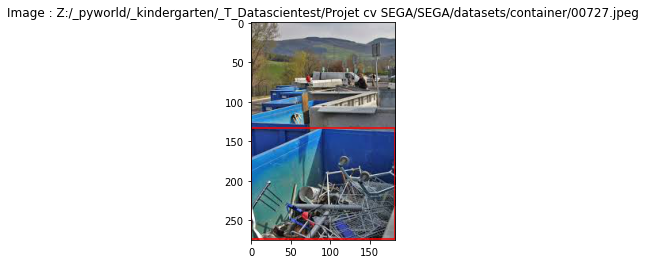

TypeError: resize_images() got an unexpected keyword argument 'antialias'

In [62]:
# ================================================================================================
# Définition de l'image pour test de la fonction de chargement d'image
i = random.choices(list(df.index), k=1)[0]
img_path = df.loc[i,"file_name"]

# ================================================================================================
# Test de la fonction
image = plt.imread(img_path)

print("==== Avant ====")
print(image.shape)
print(df.loc[i,"bbox_moy"])
show_img_bb (image, df.loc[i,"bbox_moy"][0], df.loc[i,"bbox_moy"][1], df.loc[i,"bbox_moy"][2], df.loc[i,"bbox_moy"][3], df.loc[i,"file_name"] )
plt.show()

# Application de la fonction fonctions
image_new, y_new = magic_loader(img_path, df.loc[i,"bbox_moy"],
                                fromfile = True,
                                norm = True,
                                resize = (imgRsize[0], imgRsize[0]),
                                dataAugmentation = True)

# print("==== Après ====")
# print(image_new.shape)
# print(y_new)
# show_img_bb (image_new, y_new[1]*255, y_new[2]*255, y_new[3]*255, y_new[4]*255, df.loc[i,"file_name"] )
# plt.show()

## Fonctions de chargement set background

In [ ]:
# Fonction de redimensionnement du BG
def resize_bg(X, resize=None, norm = True):

    image = tf.convert_to_tensor(X)

    # ==== Normalisation    
    if norm :
        image = tf.divide(image, 255)
    
    # ==== Redimensionnement  
    if resize!= None:
        # Redimensionnement
        image = tf.image.resize(image,
                                resize,
                                method='nearest',
                                preserve_aspect_ratio=False,
                                antialias=False,
                                name=None)
    return image

In [ ]:
# Fonction de chargement par batch
def bg_loader_batch (X, batch_rqst = 8, resize=None):
    cpt = tf.constant(0)
    for i in range(batch_rqst):
        target = np.random.choice(len(X), replace=True)
        if cpt ==0:
            xs = resize_bg(X[target], resize=resize, norm = True)
            xs = tf.expand_dims(xs, axis = 0, name=None)
        else:
            xtemp = resize_bg(X[target], resize=resize, norm = True)
            xtemp = tf.expand_dims(xtemp, axis = 0, name=None)
            xs = tf.concat([xs,xtemp], axis = 0, name='concat')
        cpt += 1

    ys = tf.zeros((batch_rqst,5),
                  dtype=tf.dtypes.float32,
                  name=None)
    return xs,ys

## Générateurs de données

In [ ]:
# Fonction du générateur d'entrainement
def generator(tf_dataset,noobj_img,batch_size, ratio=0.5):
    
    # Nombre d'images par batch différente de la source
    batch_noobj = int(batch_size*ratio)
    
    # création d'un itérateur sur le set d'origine
    iterator_tf = iter(tf_dataset)
    
    # Iterate indefinitely
    while(True):
        
        # Génération d'un batch d'images sources
        data_X, data_Y = next(iterator_tf)

        # Génération d'un batch d'images sans objets
        noobject, y_nooboject = bg_loader_batch (noobj_img,
                                                 batch_rqst = batch_size-batch_noobj,
                                                 resize = imgRsize)

        # Concatenate images
        data_X = tf.concat([data_X, noobject], axis=0)

        # Concatenate labels
        data_Y = tf.concat([data_Y, y_nooboject], axis=0)

        # Return for each iteration a batch of images/labels
        yield data_X, data_Y

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

# Définition des paramètres
ratio = 0.5
batch_size = 32

# Génération d'un dataset tf à partir du set d'origine
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_train = dataset_train.shuffle(len(X_train)).map(lambda x, y : magic_loader(x,
                                                                                   y,
                                                                                   fromfile = True,
                                                                                   norm = True,
                                                                                   resize = imgRsize,
                                                                                   dataAugmentation = True
                                                                                  ), num_parallel_calls=-1
                                                       )\
                                                    .batch(int(batch_size*ratio),drop_remainder=True)\
                                                    .cache()\
                                                    .prefetch(AUTO)\
                                                    .repeat(-1)
# Construction du générateur d'entrainement
gen_train = generator(tf_dataset = dataset_train,
                      noobj_img = background_image,
                      batch_size = batch_size,
                      ratio = ratio)

In [ ]:
# Visualisation des sorties du générateur train

X_t, y_t = next(gen_train)

for img,bbox in zip(X_t, y_t):
#     print(i,img.shape)
    show_img_bb (img, bbox[0]*255, bbox[1]*255, bbox[2]*255, bbox[3]*255, "X" )
    plt.show()

In [ ]:
# Test
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
dataset_test = dataset_test.shuffle(len(X_test)).map(lambda x, y : magic_loader(x,
                                                                                y,
                                                                                fromfile = True,
                                                                                norm = True,
                                                                                resize = imgRsize,
                                                                                dataAugmentation = False
                                                                               ))\
                                                    .batch(int(batch_size*ratio),drop_remainder=True)\
                                                    .cache()\
                                                    .prefetch(AUTO)\
                                                    .repeat(-1)

# Construction du générateur de test
gen_test = generator(tf_dataset = dataset_test,
                      noobj_img = background_image,
                      batch_size = batch_size,
                      ratio = ratio)

In [ ]:
# Visualisation des sorties du générateur test

X_t, y_t = next(gen_test)

for img,bbox in zip(X_t, y_t):
#     print(i,img.shape)
    show_img_bb (img, bbox[0]*255, bbox[1]*255, bbox[2]*255, bbox[3]*255, "X" )
    plt.show()

# Modélisation

## Partrie encoder

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

# Load the model efficientNet
TL_model = EfficientNetB0(include_top=False, input_shape=(imgRsize[0],imgRsize[1],3))

# Freeze the blackbone
for layer in TL_model.layers:
    layer.trainable = False

## Partie régression

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model


input_model = Input(shape=[256,256,3])
feature = TL_model(input_model)
x = GlobalAveragePooling2D()(feature)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)

object_prob = Dense(1, activation='sigmoid',name="object_prob")(x)
regression = Dense(4, activation='linear',name="bb_coord")(x)
output_model = tf.concat([regression,object_prob], axis=-1)

model = Model(inputs=input_model, outputs=output_model)
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

## Metrics

Définition de la métrique IOU sur les BB uniquement pour les cas où les objets sont réellement présents.

In [ ]:
def metric_iou(y_true, y_pred):
    
    # application du format float32
    p_object = tf.cast(y_true[:,4], tf.float32)
    y_true = tf.cast(y_true[:,0:4], tf.float32)
    y_pred = tf.cast(y_pred[:,0:4], tf.float32)
    
    # Récupération des x,y ,w et h pour l'origine et la prédiction
    xtrue, ytrue, wtrue, htrue = y_true[:,0], y_true[:,1], y_true[:,2], y_true[:,3]
    xpred, ypred, wpred, hpred = tf.abs(y_pred[:,0]), tf.abs(y_pred[:,1]), tf.abs(y_pred[:,2]), tf.abs(y_pred[:,3]) 
    
    # calcul xA, yA, xB, yB
    xA = tf.maximum(xtrue ,xpred )
    yA = tf.maximum(ytrue ,ypred )
    xB = tf.minimum(xtrue + wtrue,xpred + wpred )
    yB = tf.minimum(ytrue + htrue,ypred + hpred )
    
    # Intersection area
    intersect_area = tf.nn.relu(xB - xA) * tf.nn.relu(yB - yA)
    # or 
    # intersect_area = tf.maximum(xB - xA, 0) * tf.maximum(yB - yA, 0)
    
    # Union area
    true_area = wtrue * htrue
    pred_area = wpred * hpred
    union_area = pred_area + true_area - intersect_area
    
    # Calcul de l'IOU uniquement si p_object = 1
    return tf.reduce_sum(p_object*intersect_area / union_area)/tf.reduce_sum(p_object)

Définition de la métrique binary_accuracy pour la probabilité de présence d'objet.

In [ ]:
def metric_confident(y_true, y_pred):
    return tf.keras.metrics.binary_accuracy(y_true[:,4], y_pred[:,4])

## Fonction de perte

In [30]:
def coord_loss(y_true, y_pred):
    
    # Conversion en tenseurs
    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)
    
    # Répartition des valeurs
    xpred = y_pred[:,0]
    xtrue = y_true[:,0]
    ypred = y_pred[:,1]
    ytrue = y_true[:,1]
    wpred = y_pred[:,2]
    wtrue = y_true[:,2]
    hpred = y_pred[:,3]
    htrue = y_true[:,3]
    
    # Calcul des différents membres de la formule
    a = tf.math.square(xpred - xtrue)
    b = tf.math.square(ypred - ytrue)
    c = tf.math.square(tf.math.sqrt(tf.math.abs(wpred))-tf.math.sqrt(wtrue))
    d = tf.math.square(tf.math.sqrt(tf.math.abs(hpred))-tf.math.sqrt(htrue))

    return tf.reduce_mean((a + b + c + d), axis=-1)

Loss de classification pour la partie présence d'objets.

In [31]:
def loss_classification(y_true, y_pred):
    return tf.keras.losses.BinaryCrossentropy()(y_true[:,4], y_pred[:,4])

Construction de la loss totale.

In [32]:
lambda_coord = 10
lambda_class = 1

def loss_function(y_true, y_pred):
    loss_coord = coord_loss(y_true[:,0:4], y_pred[:,0:4])
    loss_class = loss_classification(y_true, y_pred)
    total_loss = lambda_coord*y_true[:,4]*loss_coord + lambda_class*loss_class
#     total_loss = lambda_coord*loss_coord + lambda_class*loss_class
    return total_loss


In [ ]:
lambda_regression = 1
lambda_classification = 1

def loss_regression(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true-y_pred), axis=-1)

def loss_classification(y_true, y_pred):
    return tf.keras.losses.BinaryCrossentropy()(y_true[:,4], y_pred[:,4])


def loss_function(y_true, y_pred):
    return lambda_regression*y_true[:,4]*loss_regression(y_true[:,0:4], y_pred[:,0:4]) + lambda_classification*loss_classification(y_true, y_pred)


## Compilation

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

model.compile(loss=loss_function,
              optimizer=Adam(0.1),
              metrics = [metric_iou, metric_confident]
             )

## Callbacks

In [ ]:
from tensorflow.keras import callbacks

In [ ]:
# Réduction du lr sur un plateau
lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1,
                                         patience=3,
                                         verbose=2,
                                         mode='min')

In [ ]:
# Callback pour l'arrêt anticipé si les perfos ne s'améliorent pas.
early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                         patience=10,
                                         mode='min',
                                         restore_best_weights=True)

## Entrainement

In [ ]:
nb_epochs = 20
history = model.fit(dataset_train,
                    steps_per_epoch = (int(len(X_train)//batch_size)),
                    epochs=nb_epochs,
                    validation_data = dataset_train,
                    validation_steps = (int(len(X_test)//batch_size)),
                    callbacks=[early_stopping,lr_plateau]
                   )

In [ ]:
# Config
first_var = 'loss'
second_var = 'metric_iou'
history = history

# Mise à l'échelle des nb d'epochs
tick_locs = list(range(0,nb_epochs))
tick_lbls = list(range(1,nb_epochs+1))

plt.figure(figsize=(14,4))
# Graphe var 1
plt.subplot(121)
plt.plot(history.history[first_var])
plt.plot(history.history['val_'+first_var])
plt.title(f'Model {first_var} by epoch')
plt.ylabel(first_var)
plt.xlabel('epoch')
plt.xticks(tick_locs, tick_lbls, rotation = 0)
plt.legend(['train', 'validation'], loc='best')

# Graphe var 2
plt.subplot(122)
plt.plot(history.history[second_var])
plt.plot(history.history['val_'+second_var])
plt.title(f'Model {second_var} by epoch')
plt.ylabel(second_var)
plt.xlabel('epoch')
plt.xticks(tick_locs, tick_lbls, rotation = 0)
plt.legend(['train', 'validation'], loc='best')
plt.show()

# Config
first_var = 'metric_confident'
second_var = 'lr'
history = history

# Mise à l'échelle des nb d'epochs
tick_locs = list(range(0,nb_epochs))
tick_lbls = list(range(1,nb_epochs+1))

plt.figure(figsize=(14,4))
# Graphe var 1
plt.subplot(121)
plt.plot(history.history[first_var])
plt.plot(history.history['val_'+first_var])
plt.title(f'Model {first_var} by epoch')
plt.ylabel(first_var)
plt.xlabel('epoch')
plt.xticks(tick_locs, tick_lbls, rotation = 0)
plt.legend(['train', 'validation'], loc='best')

# Graphe var 2
plt.subplot(122)
plt.plot(history.history[second_var])
plt.title(f'Model {second_var} by epoch')
plt.ylabel(second_var)
plt.xlabel('epoch')
plt.xticks(tick_locs, tick_lbls, rotation = 0)
plt.show()

## Inférence

In [ ]:
X_t, y_t = next(gen_test)

In [ ]:
# Définition de l'image et des coordonnées pour test du modèle
i = random.choices(list(range(batch_size)), k=1)[0]
img_ori = X_t[i]
coord_ori = y_t[i]

# Affichage de la BB d'origine
print("==== Image et BB source ====")
show_img_bb (img_ori, coord_ori[0]*255, coord_ori[1]*255, coord_ori[2]*255, coord_ori[3]*255, "X" )
plt.show()

# Affichage de la BB prédite
print("==== Image et BB après prédiction ====")
x, y, w, h, p = model.predict(tf.expand_dims(X_t[i], axis=0))[0]
print(f"Probabilité de présence d'objet : {p}")
show_img_bb (img_ori, x*255, y*255, w*255, h*255, "X" )
plt.show()

In [ ]:
for img in X_t:
    print("==== Image et BB après prédiction ====")
    print(f"Probabilité de présence d'objet : {p}")
    x, y, w, h, p = model.predict(tf.expand_dims(img, axis=0))[0]
    show_img_bb (img, x*255, y*255, w*255, h*255, "X" )
    plt.show()

In [ ]:
model.predict(X_t)

## Defreeze

In [57]:
for layer in TL_model.layers:
    print(layer.name)
    print("========================",layer.trainable)

input_6
======================== False
rescaling_4
======================== False
normalization_4
======================== False
tf.math.truediv_4
======================== False
stem_conv_pad
======================== False
stem_conv
======================== False
stem_bn
======================== False
stem_activation
======================== False
block1a_dwconv
======================== False
block1a_bn
======================== False
block1a_activation
======================== False
block1a_se_squeeze
======================== False
block1a_se_reshape
======================== False
block1a_se_reduce
======================== False
block1a_se_expand
======================== False
block1a_se_excite
======================== False
block1a_project_conv
======================== False
block1a_project_bn
======================== False
block2a_expand_conv
======================== False
block2a_expand_bn
======================== False
block2a_expand_activation
======================== False
block2

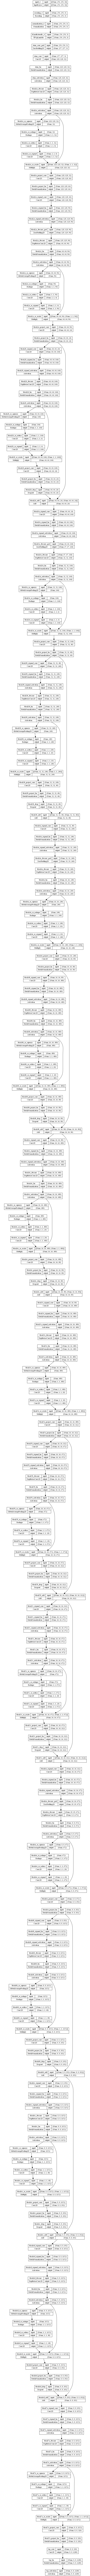

In [58]:

plot_model(TL_model, show_shapes=True)

In [59]:
# unfreeze the blackbone
for layer in TL_model.layers[-4:]:
    layer.trainable = True

In [60]:
for layer in TL_model.layers:
    print(layer.name)
    print("========================",layer.trainable)

input_6
======================== False
rescaling_4
======================== False
normalization_4
======================== False
tf.math.truediv_4
======================== False
stem_conv_pad
======================== False
stem_conv
======================== False
stem_bn
======================== False
stem_activation
======================== False
block1a_dwconv
======================== False
block1a_bn
======================== False
block1a_activation
======================== False
block1a_se_squeeze
======================== False
block1a_se_reshape
======================== False
block1a_se_reduce
======================== False
block1a_se_expand
======================== False
block1a_se_excite
======================== False
block1a_project_conv
======================== False
block1a_project_bn
======================== False
block2a_expand_conv
======================== False
block2a_expand_bn
======================== False
block2a_expand_activation
======================== False
block2

# Optim

In [ ]:
Traiter le cas où j'ai plusieurs BB sur lamême image
Est-ce qu'il ne faut pas remélanger le dataset ?
Pour les landmarks / keypoints on utilise un algo qui détecte la zone puis qui donne les landmarks à partir de la zone à traiter.
Object detection -> Yolo est top
Attention, il semble y avoir des images dupliquées dans le dataset, regarder ça dans l'explo
Mise en place d'un LR sinus
intégrer un defreeze des couches pour pour spécifier le modèle sur notre application
ceuser la data augmentation (lum / expo, ...)
Travailler sur le type de backbone (Effnet XX, ResNet, DARKNet...)
Voir l'utilisation de decay dans le lr


In [ ]:
grad_descent = keras.optimizers.SGD(learning_rate=lr, decay=lr/epochs)